In [ ]:
#Use pretrained unet network - DONE
#Add information about slice - TODAY
#Are all lungs facing the same way = TOMMOROW?
#Add information about nodule - TOMMOROW
#Lung mask as per simple thresholding? Maybe No. But do measure jaccard/dice for thresholding Vs deep learning
#Add information about patient
#Try 3D Unet
#Process data to have 2 classes - lung, Nodule
#Use Jacckard index instead of dice coefficient
#initialise using tutorial weights
#preprocess to make 0 or 1 in training data
#train on segmented lungs data using unet 
#test on validation set
#Expand data from 160 to zoom on lung
#does every CT scan have patient oriented in same way? TO BE VERIFIED

In [1]:
import SimpleITK as sitk
from tqdm import tqdm
import numpy as np
import csv
import os
from PIL import Image
import matplotlib.pyplot as plt
from glob import glob
from keras.models import Model
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from random import uniform
import bcolz
import time
from keras.layers import merge
from keras.layers.core import Lambda
from keras.models import Model
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Dropout
from keras.layers import Input, Dense
import math
import pandas as pd
numGPUs = 1

%matplotlib inline

/home/ubuntu/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
Using Theano backend.
WARNING (theano.sandbox.cuda): CUDA is installed, but device gpu is not available  (error: Unable to get the number of gpus available: unknown error)


In [2]:
%cd '/luna/home/ubuntu/data/masks'
lung_mask_files=glob("*.mhd")
%cd '/dsb/home/ubuntu/data/lungs'
lung_files=glob("*.mhd")
%cd '/luna/home/ubuntu/data/lungs'
%cd ..

/luna/home/ubuntu/data/masks
/dsb/home/ubuntu/data/lungs
/luna/home/ubuntu/data/lungs
/luna/home/ubuntu/data


In [3]:
def load_itk_image(filename):
    itkimage = sitk.ReadImage(filename)
    numpyImage = sitk.GetArrayFromImage(itkimage)
    numpyOrigin = np.array(list(reversed(itkimage.GetOrigin())))
    numpySpacing = np.array(list(reversed(itkimage.GetSpacing())))
    return numpyImage, numpyOrigin, numpySpacing

In [ ]:
#Create sample dataset - lungs and masks

CREATE_SAMPLE = False
SAMPLE_SIZE = 0.4
if CREATE_SAMPLE==True:
    os.mkdir('masks-valid')
    os.mkdir('lungs-valid')
    shuffled_files = np.random.permutation(lung_files)
    sample_size = int(round(len(lung_mask_files) * SAMPLE_SIZE,0))
    for i in range(sample_size):
        shuffled_files_raw = shuffled_files[i].replace("mhd","zraw")
        shuffled_files_raw_lungs = shuffled_files[i].replace("mhd","raw")
        os.rename('masks/' + shuffled_files[i], 'masks-valid/' + shuffled_files[i])
        os.rename('masks/' + shuffled_files_raw, 'masks-valid/' + shuffled_files_raw) 
        os.rename('lungs/' + shuffled_files[i], 'lungs-valid/' + shuffled_files[i]) 
        os.rename('lungs/' + shuffled_files_raw_lungs, 'lungs-valid/' + shuffled_files_raw_lungs) 
# TBD LATER HANDLE 48 missing lungs in dataset!

In [4]:
%cd '/dsb/home/ubuntu/data/lungs'
lungs = glob('*.mhd')
num_lungs = len(lungs)
%cd '/luna/home/ubuntu/data/lungs'
%cd '/dsb/home/ubuntu/data/lungs-valid'
lungs_valid = glob('*.mhd')
num_lungs_valid = len(lungs_valid)
%cd '/luna/home/ubuntu/data/lungs'
%cd ..

/dsb/home/ubuntu/data/lungs
/luna/home/ubuntu/data/lungs
/dsb/home/ubuntu/data/lungs-valid
/luna/home/ubuntu/data/lungs
/luna/home/ubuntu/data


In [22]:
#Load data

## load test lung
img_path = "/dsb/home/ubuntu/data/lungs/1.3.6.1.4.1.14519.5.2.1.6279.6001.534006575256943390479252771547.mhd"
numpyImage, numpyOrigin, numpySpacing = load_itk_image(img_path)
print numpyImage.shape
print numpyOrigin
print numpySpacing

(545, 512, 512)
[-333.809998 -198.5      -205.199997]
[ 0.625       0.72265601  0.72265601]


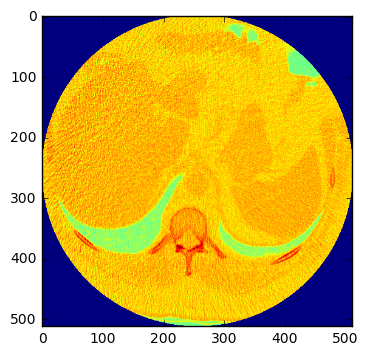

In [29]:
plt.imshow(numpyImage[100])

In [ ]:
## load test Mask
img_path = "masks/1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860.mhd"
numpyImage, numpyOrigin, numpySpacing = load_itk_image(img_path)
print numpyImage.shape
print numpyOrigin
print numpySpacing

In [ ]:
plt.imshow(numpyImage[100])

In [ ]:
mask = np.ndarray([512,512],dtype=np.int8)
mask[:] = 0
mask = numpyImage>0
plt.imshow(mask[100])

In [5]:
def save_array(fname, arr):
    c=bcolz.carray(arr, rootdir=fname, mode='w')
    c.flush()

def load_array(fname):
    return bcolz.open(fname)[:]

In [ ]:
#Scale to all lungs, store in 10 datasets after resizing to 160 X 160 pixels

FULL_LOAD = False

if FULL_LOAD:
    max_images = int(round(266 * num_lungs * 0.10,0))
    final_images = np.ndarray([max_images,1,512,512],dtype=np.float32)
    final_masks = np.ndarray([max_images,1,512,512],dtype=np.float32)
    final_lungs = np.ndarray([max_images,2,3],dtype=np.float32)
    final_slice_indices = np.ndarray([max_images,2],dtype=np.float32)

    num_images = 0
    lung_no = 0
    fcount = 0
    
    for l in tqdm(lungs):
        lung_no += 1
        numpyImage, numpyOriginImage, numpySpacingImage = load_itk_image('/dsb/home/ubuntu/data/lungs/' + l)
        numpyMask, numpyOriginMask, numpySpacingMask = load_itk_image('masks/' + l)
        mask = np.ndarray([512,512],dtype=np.int8)
        mask[:] = 0
        mask = numpyMask>0
        num_slices = numpyImage.shape[0]
        for i in range(num_slices):
            if uniform(0, 1) < 1.01:
                if num_images < max_images:
                    final_images[num_images,0] = numpyImage[i]
                    final_masks[num_images,0] = mask[i]
                    final_slice_indices[num_images,0] = lung_no
                    final_slice_indices[num_images,1] = i
                    final_lungs[num_images,0] = numpyOriginImage
                    final_lungs[num_images,1] = numpySpacingImage
                    num_images += 1
                else:
                    #Resize final_images and final_masks to 160 X 160
                    numImages = final_images.shape[0]
                    final_images_160 = np.ndarray([numImages,8,160,160],dtype=np.float32)
                    final_masks_160 = np.ndarray([numImages,1,160,160],dtype=np.float32)
                    pixels_to_keep = range(15,495,3)
                    pixels = range(160)
                    for i in range(numImages-1):
                        for j in pixels:
                            for k in pixels:
                                final_images_160[i,0,j,k] = final_images[i,0,15+j*3,15+k*3]
                                final_images_160[i,1,j,k] = final_images[i,0,15+j*3,15+k*3]
                                final_images_160[i,2,j,k] = final_images[i,0,15+j*3,15+k*3]
                                final_images_160[i,3,j,k] = final_images[i,0,15+j*3,15+k*3]
                                final_images_160[i,4,j,k] = final_images[i,0,15+j*3,15+k*3]
                                final_images_160[i,5,j,k] = final_images[i,0,15+j*3,15+k*3]
                                final_images_160[i,6,j,k] = final_images[i,0,15+j*3,15+k*3]
                                final_images_160[i,7,j,k] = final_images[i,0,15+j*3,15+k*3]
                                final_masks_160[i,0,j,k] = final_masks[i,0,15+j*3,15+k*3]
                    final_images = final_images_160
                    final_masks = final_masks_160
                    save_array('/dsb/home/ubuntu/data/temp/final_images_%d.dat' % (fcount), final_images)
                    save_array('final_masks_%d.dat' % (fcount), final_masks)
                    save_array('final_slice_indices_%d.dat' % (fcount), final_slice_indices)
                    save_array('final_lungs_%d.dat' % (fcount), final_lungs)
                    final_images = np.ndarray([max_images,1,512,512],dtype=np.float32)
                    final_masks = np.ndarray([max_images,1,512,512],dtype=np.float32)
                    final_lungs = np.ndarray([max_images,2,3],dtype=np.float32)
                    final_slice_indices = np.ndarray([max_images,2],dtype=np.float32)
                    fcount += 1
                    num_images = 0

In [ ]:
if FULL_LOAD:
    del(final_images)
    del(final_masks)
    del(final_slice_indices)
    del(final_lungs)
    del(final_images_160)
    del(final_masks_160)

In [ ]:
#Scale to all lungs in validation set, store in 10 datasets after resizing to 160 X 160 pixels

FULL_LOAD = False

if FULL_LOAD:
    max_images = int(round(266 * num_lungs_valid * 0.10,0))
    final_images = np.ndarray([max_images,1,512,512],dtype=np.float32)
    final_masks = np.ndarray([max_images,1,512,512],dtype=np.float32)
    final_lungs = np.ndarray([max_images,2,3],dtype=np.float32)
    final_slice_indices = np.ndarray([max_images,2],dtype=np.float32)

    num_images = 0
    lung_no = 0
    fcount = 0
    
    for l in tqdm(lungs_valid):
        lung_no += 1
        numpyImage, numpyOriginImage, numpySpacingImage = load_itk_image('/dsb/home/ubuntu/data/lungs-valid/' + l)
        numpyMask, numpyOriginMask, numpySpacingMask = load_itk_image('masks-valid/' + l)
        mask = np.ndarray([512,512],dtype=np.int8)
        mask[:] = 0
        mask = numpyMask>0
        num_slices = numpyImage.shape[0]
        for i in range(num_slices):
            if uniform(0, 1) < 1.01:
                if num_images < max_images:
                    final_images[num_images,0] = numpyImage[i]
                    final_masks[num_images,0] = mask[i]
                    final_slice_indices[num_images,0] = lung_no
                    final_slice_indices[num_images,1] = i
                    final_lungs[num_images,0] = numpyOriginImage
                    final_lungs[num_images,1] = numpySpacingImage
                    num_images += 1
                else:
                    #Resize final_images and final_masks to 160 X 160
                    numImages = final_images.shape[0]
                    final_images_160 = np.ndarray([numImages,8,160,160],dtype=np.float32)
                    final_masks_160 = np.ndarray([numImages,1,160,160],dtype=np.float32)
                    pixels_to_keep = range(15,495,3)
                    pixels = range(160)
                    for i in range(numImages-1):
                        for j in pixels:
                            for k in pixels:
                                final_images_160[i,0,j,k] = final_images[i,0,15+j*3,15+k*3]
                                final_images_160[i,1,j,k] = final_images[i,0,15+j*3,15+k*3]
                                final_images_160[i,2,j,k] = final_images[i,0,15+j*3,15+k*3]
                                final_images_160[i,3,j,k] = final_images[i,0,15+j*3,15+k*3]
                                final_images_160[i,4,j,k] = final_images[i,0,15+j*3,15+k*3]
                                final_images_160[i,5,j,k] = final_images[i,0,15+j*3,15+k*3]
                                final_images_160[i,6,j,k] = final_images[i,0,15+j*3,15+k*3]
                                final_images_160[i,7,j,k] = final_images[i,0,15+j*3,15+k*3]
                                final_masks_160[i,0,j,k] = final_masks[i,0,15+j*3,15+k*3]
                    final_images = final_images_160
                    final_masks = final_masks_160
                    save_array('/dsb/home/ubuntu/data/temp/final_images_valid_%d.dat' % (fcount), final_images)
                    save_array('final_masks_valid_%d.dat' % (fcount), final_masks)
                    save_array('final_slice_indices_valid_%d.dat' % (fcount), final_slice_indices)
                    save_array('final_lungs_valid_%d.dat' % (fcount), final_lungs)
                    final_images = np.ndarray([max_images,1,512,512],dtype=np.float32)
                    final_masks = np.ndarray([max_images,1,512,512],dtype=np.float32)
                    final_lungs = np.ndarray([max_images,2,3],dtype=np.float32)
                    final_slice_indices = np.ndarray([max_images,2],dtype=np.float32)
                    fcount += 1
                    num_images = 0

In [ ]:
if FULL_LOAD:
    del(final_images)
    del(final_masks)
    del(final_slice_indices)
    del(final_lungs)
    del(final_images_160)
    del(final_masks_160)

In [ ]:
df_node = pd.read_csv('/dsb/home/ubuntu/data/annotations_id.csv')
df_node = df_node.dropna()
df_node.head()

In [ ]:
def makeNoduleMasks():
    numImages = final_lungs.shape[0]
    NoduleMasks = np.ndarray([numImages,1,160,160],dtype=np.uint8)
    masks = np.ndarray([160,160],dtype=np.uint8)
    NoduleMasks[:] = 0
    for imgIndex in range(numImages):
        mini_df = df_node[df_node["lungid"]==float(final_slice_indices[imgIndex,0])] #get all nodules associate with file
        masks[:] = 0
        if mini_df.shape[0]>0:
            origin = final_lungs[int(final_slice_indices[imgIndex,0]),0]         # x,y,z  Origin in world coordinates (mm)
            spacing = final_lungs[int(final_slice_indices[imgIndex,0]),1]        # spacing of voxels in world coor. (mm)
            for node_idx, cur_row in mini_df.iterrows():       
                node_x = cur_row["coordX"]
                node_y = cur_row["coordY"]
                node_z = cur_row["coordZ"]
                diam = cur_row["diameter_mm"]
                center = np.array([node_z, node_y,node_x])                   # nodule center in world coor. (mm)
                v_center = np.rint((center-origin)/spacing)                  # nodule center in voxel space 
                radius_z = int(np.round((diam/spacing[0])/2,0))              # nodule radius in voxel space 
                radius_y = int(np.round((diam/spacing[1])/2,0))              # nodule radius in voxel space 
                radius_x = int(np.round((diam/spacing[2])/2,0))              # nodule radius in voxel space 
                image_z = final_slice_indices[imgIndex,1]+1                  # Assumes that first slice starts at z=0 in voxel space
                if (v_center[0]+radius_z>=image_z) & (v_center[0]-radius_z<=image_z):
                    pixel_nodule_radius_projected_x = np.sqrt(max(0,np.square(radius_x) 
                                                                  - np.square(v_center[0]-image_z)))     # in voxel space 
                    pixel_nodule_radius_projected_y = np.sqrt(max(0,np.square(radius_y) 
                                                                  - np.square(v_center[0]-image_z)))     # in voxel space 
                    pixels_to_keep = range(160)
                    for pixel_x in pixels_to_keep:
                        for pixel_y in pixels_to_keep:
                            pixel_x_adj = pixel_x * 3 + 16
                            pixel_y_adj = pixel_y * 3 + 16
                            distance_x = abs(pixel_x_adj - v_center[2])
                            distance_y = abs(pixel_y_adj - v_center[1])
                            if (distance_x <= pixel_nodule_radius_projected_x) & (distance_y <= pixel_nodule_radius_projected_y):
                                   masks[pixel_y,pixel_x] = 1
            NoduleMasks[imgIndex,0] = masks
    return NoduleMasks

In [ ]:
#Create Nodule Masks for training data
for i in range(10):  
    final_masks = load_array('/luna/home/ubuntu/data/final_masks_%d.dat'%i)
    final_lungs = load_array('/luna/home/ubuntu/data/final_lungs_%d.dat'%i)
    final_slice_indices = load_array('/luna/home/ubuntu/data/final_slice_indices_%d.dat'%i)
    save_array('/luna/home/ubuntu/data/final_nodule_masks_%d.dat'%i,makeNoduleMasks())

#Repeat for validation
for i in range(9):  
    final_masks = load_array('/luna/home/ubuntu/data/final_masks_valid_%d.dat'%i)
    final_lungs = load_array('/luna/home/ubuntu/data/final_lungs_valid_%d.dat'%i)
    final_slice_indices = load_array('/luna/home/ubuntu/data/final_slice_indices_valid_%d.dat'%i)
    save_array('/luna/home/ubuntu/data/final_nodule_masks_valid_%d.dat'%i,makeNoduleMasks())

In [ ]:
#Convert to the shape and scale that unet expects
def standardizeImage(final_images_160):    
    #Normalise data before training
    mean = -771.49414                         
    std = 959.30872
    final_images_160 = final_images_160 - mean
    final_images_160 = final_images_160 / std
    minHU = np.percentile(final_images_160,1)
    maxHU = np.percentile(final_images_160,99)
    final_images_160 = np.clip(final_images_160,minHU,maxHU)
    OldRange = (maxHU - minHU)  
    NewRange = 1 - (-1)  
    final_images_160 = ((((final_images_160 - minHU) / OldRange)) * NewRange) - 1
    return final_images_160

In [ ]:
def get_unet():
    inputs = Input((8,160,160))
    conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(inputs)
    conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(pool1)
    conv2 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(pool2)
    conv3 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(pool3)
    conv4 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(pool4)
    conv5 = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(conv5)

    up6 = merge([UpSampling2D(size=(2, 2))(conv5), conv4], mode='concat', concat_axis=1)
    conv6 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(up6)
    conv6 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(conv6)

    up7 = merge([UpSampling2D(size=(2, 2))(conv6), conv3], mode='concat', concat_axis=1)
    conv7 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(up7)
    conv7 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(conv7)

    up8 = merge([UpSampling2D(size=(2, 2))(conv7), conv2], mode='concat', concat_axis=1)
    conv8 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(up8)
    conv8 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv8)

    up9 = merge([UpSampling2D(size=(2, 2))(conv8), conv1], mode='concat', concat_axis=1)
    model = Model(input=inputs, output=up9)

    return model

In [ ]:
#Precompute features till layer "up9"
def preComputeFeatures(final_images_160,chunkIndex,valid):
    final_nodule_masks = load_array('/luna/home/ubuntu/data/final_nodule_masks'+valid+'_%d.dat'%chunkIndex)
    final_masks = load_array('/luna/home/ubuntu/data/final_masks'+valid+'_%d.dat'%chunkIndex)
    numImages = final_nodule_masks.shape[0]
    tempImages = np.ndarray([numImages,8,160,160],dtype=np.uint8)
    tempNodules = np.ndarray([numImages,1,160,160],dtype=np.uint8)
    tempMasks = np.ndarray([numImages,1,160,160],dtype=np.uint8)
    fileChunkSize = 1000
    sampledImagesCount = 0
    for i in range(numImages):
        lung_pixel_count = np.sum(final_masks[i,0])
        nodule_pixel_count = np.sum(final_nodule_masks[i,0])
        if nodule_pixel_count>0:
            random_seed = 0
        else:
            if lung_pixel_count > 0:
                random_seed = uniform(0,1)
            else:
                random_seed = uniform(0,3)
        if random_seed < 0.1:
            tempImages[sampledImagesCount,0] = final_images_160[i,0]
            tempImages[sampledImagesCount,1] = final_images_160[i,0]
            tempImages[sampledImagesCount,2] = final_images_160[i,0]
            tempImages[sampledImagesCount,3] = final_images_160[i,0]
            tempImages[sampledImagesCount,4] = final_images_160[i,0]
            tempImages[sampledImagesCount,5] = final_images_160[i,0]
            tempImages[sampledImagesCount,6] = final_images_160[i,0]
            tempImages[sampledImagesCount,7] = final_images_160[i,0]
            tempMasks[sampledImagesCount,0] = final_masks[i,0]
            tempNodules[sampledImagesCount,0] = final_nodule_masks[i,0]
            sampledImagesCount += 1
    if sampledImagesCount>0:
        final_images_160 = np.ndarray([sampledImagesCount,8,160,160],dtype=np.uint8)
        final_images_160 = tempImages
        final_masks = np.ndarray([sampledImagesCount,1,160,160],dtype=np.uint8)
        final_masks = tempMasks
        final_nodule_masks = np.ndarray([sampledImagesCount,1,160,160],dtype=np.uint8)
        final_nodule_masks = tempNodules
        numImages = final_images_160.shape[0]
        numIterations = int(math.ceil(numImages/fileChunkSize))
        model = get_unet()
        model.load_weights('../unet_42quality.hdf5',by_name=True)
        for i in range(numIterations):
            final_images_features = model.predict(final_images_160[(i*fileChunkSize):min(numImages,(i+1)*fileChunkSize)], batch_size=4)
            save_array('/luna/home/ubuntu/data/features/final_images_features'+valid+'_%d_%d.dat' 
                       % (chunkIndex,i), final_images_features)  
            save_array('/luna/home/ubuntu/data/features/final_images_nodule_masks'+valid+'%d_%d.dat' 
                       % (chunkIndex,i), final_nodule_masks)  
            save_array('/luna/home/ubuntu/data/features/final_images_masks'+valid+'_%d_%d.dat' 
                       % (chunkIndex,i), final_masks)  

In [ ]:
#Precompute features for training dataset
for f in tqdm(range(8,10)):
    preComputeFeatures(standardizeImage(load_array('/dsb/home/ubuntu/data/temp/final_images_%d.dat'%f)),f,"") 

#Repeat for validation dataset
for f in tqdm(range(9)):
    preComputeFeatures(standardizeImage(load_array('/dsb/home/ubuntu/data/temp/final_images_valid_%d.dat'%f)),f,"_valid") 

In [6]:
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_np(y_true,y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [7]:
smooth_j = 1e-12

def jaccard_coef(y_true, y_pred):
    # __author__ = Vladimir Iglovikov
    intersection = K.sum(y_true * y_pred, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])
    jac = (intersection + smooth_j) / (sum_ - intersection + smooth_j)
    return K.mean(jac)

def jaccard_coef_int(y_true, y_pred):
    # __author__ = Vladimir Iglovikov
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    intersection = K.sum(y_true * y_pred_pos, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred_pos, axis=[0, -1, -2])
    jac = (intersection + smooth_j) / (sum_ - intersection + smooth_j)
    return K.mean(jac)


def jaccard_coef_loss(y_true, y_pred):
    return -jaccard_coef(y_true, y_pred)

In [8]:
def get_last_layer(s):
    inputs = Input(shape=s)
    conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(inputs)
    conv2 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv1)
    conv3 = Convolution2D(1,1, 1, activation='sigmoid')(conv2)
    model = Model(input=[inputs], output=conv3)    
    return model  

lrg_model = get_last_layer((96,160,160))   
lrg_model.summary()
lrg_model.compile(Adam(lr=0.001), loss=dice_coef_loss, metrics=[jaccard_coef_int,dice_coef])

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 96, 160, 160)  0                                            
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 32, 160, 160)  27680       input_1[0][0]                    
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 32, 160, 160)  9248        convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_3 (Convolution2D)  (None, 1, 160, 160)   33          convolution2d_2[0][0]            
Total params: 36961
_______________________________________________________________________

In [28]:
def generate_training_batches(batch_size,data_size):
    for i in range(data_size):
        featuresFiles = glob('final_images_features_%d_*.dat'%i)
        featuresFiles = np.random.permutation(featuresFiles)
        for f in featuresFiles:
            features = load_array(f)
            masks = load_array(f.replace("images_features","images_masks"))
            noduleMasks = load_array(f.replace("images_features","images_masks"))
            numRows = features.shape[0]
            count = 0
            x = np.ndarray([batch_size,1,160,160],dtype=np.float32)
            y = np.ndarray([batch_size,1,160,160],dtype=np.float32)
            while (count < numRows) and (count+batch_size<numRows):
                x = features[count:(count+batch_size)]
                y = masks[count:(count+batch_size)]
                count += batch_size
                yield (x,y)

def generate_validation_batches(batch_size,data_size):
    for i in range(data_size):
        featuresFiles = glob('final_images_features_valid_%d_*.dat'%i)
        for f in featuresFiles:
            features = load_array(f)
            masks = load_array(f.replace("images_features","images_masks"))
            numRows = features.shape[0]
            count = 0
            while (count < numRows) and (count+batch_size<numRows):
                x = features[count:(count+batch_size)]
                y = masks[count:(count+batch_size)]
                count += batch_size
                yield (x,y)

In [30]:
def trainMyNw(nb_epoch):
    best_loss_metric = 0
    f = open('/luna/home/ubuntu/log.txt', 'w')
    print "training network using features from:"
    %cd '/luna/home/ubuntu/data/features'
    for e in range(nb_epoch):
        print 'epoch %d:'%e
        start = time.clock()
        for x,y in generate_training_batches(32,1):
            lrg_model.fit(x, y, batch_size = 32, nb_epoch=1, verbose=0,shuffle=True)
        for x,y in generate_validation_batches(32,1):
            loss_metrics = lrg_model.evaluate(x, y, batch_size = 32, verbose=0)
        print lrg_model.metrics_names,loss_metrics, "time :", time.clock() - start
        f.write(''.join((str(lrg_model.metrics_names),str(loss_metrics), "time :", str(time.clock() - start))))
        if (loss_metrics[0]<best_loss_metric):
            lrg_model.save_weights('/luna/home/ubuntu/lung_mask_best.hdf5') 
            best_loss_metric = loss_metrics[0]
    f.close() 
    return loss_metrics
# Early stopping

Train the network

In [ ]:
lrg_model.optimizer.lr = 1e-3
loss_metrics=trainMyNw(3)
lrg_model.optimizer.lr = 1e-4
loss_metrics=trainMyNw(10)        
lrg_model.save_weights('/luna/home/ubuntu/lung_mask.hdf5')

training network using features from:
/luna/home/ubuntu/data/features
epoch 0:
